# **Intoduction to Machine Learning to Predict Disease Protein Association**

By: Anamika Yadav

## Table of Contents:
* [Introduction](#introduction)
* [Install the requirements](#ps)
* [Protein Protein Interaction Network](#ppi)
* [MeSH similarity matrix](#mesh)
* [Disease Protein Association matrix using OMIM](#omim)
* [Map MeSH and OMIM entry to build a comprehensive Disease-protein-association network](#map)
* [Final Graph](#graph)
* [Node2vec to learn node embeddings](#node2vec)
* [SVDD to construct the optimized hypersphere](#svdd)
* [Random Forest Classifier](#rf)

## **Introduction**

In this tutorial we'll predict protein disease association to identify potential drug targets associated with given disease.

We will start by constructing and analyse a heterogeneous relationship network, integrating data from several biological databases. Human protein-protein interactions sourced from the HIPPIE database, disease-protein associations from the Uniprot database, and disease-disease similarities from the MeSH database. The goal is to predict potential disease-protein associations using machine learning techniques.

First, a heterogeneous network is constructed using these datasets. The node2vec algorithm is then applied to the network to generate embedding features for both disease and protein nodes. The disease-protein association features are formed by concatenating the latent representations of diseases and proteins.

Next, the Support Vector Data Description (SVDD) algorithm is used to refine the dataset by constructing an optimized hypersphere around the known disease-protein associations. This helps in identifying and screening out reliable disease-protein non-association pairs.

Finally, a Random Forest model is trained using the association and non-association pairs to predict potential disease-protein associations. This approach allows for the identification of novel connections between diseases and proteins, which could be valuable for drug discovery and disease research.

## **Install the requirements**

In [ ]:
!pip install ssmpy
!pip install rdflib==5.0.0
!pip install scipy
!pip install biopython
!pip install karateclub
!pip install node2vec
!pip install tabulate
#Upgrade numpy if you face numpy compatibility issues
# !pip install --upgrade numpy


INFO: pip is looking at multiple versions of ssmpy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: rdflib
    Found existing installation: rdflib 7.0.0
    Uninstalling rdflib-7.0.0:
      Successfully uninstalled rdflib-7.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 644.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.18.0 requires pandas>=1.5.0, but you have pandas 1.3.5 which is incompatible.
bigframes 1.17.0 requires pandas>=1.5.3, but you have pandas 1.3.5 which is incompatible.
cudf-cu12 24.4.1 require

In [ ]:
import re
import numpy as np
import pandas as pd
from scipy.io import savemat
from scipy.sparse import csr_matrix
from Bio import SeqIO
import requests
from tabulate import tabulate
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import os
import random

## **Building Protein Protein Interaction Network**

Protein-protein interaction (PPI) refers to the physical contact between two or more protein molecules, often resulting in a functional biological effect. These interactions are fundamental to most biological processes, as proteins work together in networks or complexes to carry out various cellular tasks, such as signal transduction, metabolic pathways, gene regulation, and immune responses.

Protein-protein interactions (PPIs) play a critical role in disease association because they are fundamental to many cellular functions and processes. Abnormal or disrupted PPIs can lead to the development and progression of various diseases, including cancer, neurodegenerative disorders, and infectious diseases. Studying PPIs allows researchers to identify proteins that are central to specific disease pathways. For example, proteins involved in immune response, cell cycle regulation, or apoptosis often form key interaction networks linked to disease states. By mapping these interactions, researchers can discover disease-related proteins that play central roles in the PPI network.Understand how specific proteins contribute to the disease, providing insights into disease etiology and progression.

PPIs are increasingly targeted for drug discovery because intervening in these interactions can restore normal cellular functions or prevent disease progression. Drugs can be designed to inhibit or block specific PPIs that drive disease processes, such as those in cancer signaling pathways.


**Human Integrated Protein-Protein Interaction Reference**

The HIPPIE (Human Integrated Protein-Protein Interaction Reference) dataset is a curated collection of experimentally verified human protein-protein interactions (PPIs). It integrates data from multiple public databases and refines it by scoring interactions based on their reliability, confidence, and biological relevance. HIPPIE is a valuable resource for researchers studying biological pathways, disease mechanisms, and for applications in drug discovery.



**Download and Pre-process HIPPIE Dataset**

In [ ]:
# Define the URL and the local filename
url = 'https://cbdm-01.zdv.uni-mainz.de/~mschaefer/hippie/HIPPIE-current.mitab.txt'
local_filename = 'HIPPIE-current.mitab.txt'

# Send a GET request to the URL
response = requests.get(url, stream=True)

# Check if the request was successful
if response.status_code == 200:
    # Open a local file in write-binary mode and write the content of the response
    with open(local_filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):  # Write in chunks to handle large files
            f.write(chunk)
    print(f"File downloaded successfully and saved as {local_filename}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully and saved as HIPPIE-current.mitab.txt


In [ ]:
file_path = 'HIPPIE-current.mitab.txt'
PPI_data = pd.read_csv(file_path, sep='\t', header=0)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
print(tabulate(PPI_data.head(), headers='keys', tablefmt='grid'))

+----+-------------------+-------------------+------------------------+------------------------+------------------------+------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+--------------------------+--------------------------+---------------------+----------------------------------------------------------------+---------------------------+--------------------+-----------------------------+--------------------------+--------------------------+
|    | ID Interactor A   | ID Interactor B   | Alt IDs Interactor A   | Alt IDs Interactor B   | Aliases Interactor A   | Aliases 

In [ ]:
# Read the HIPPIE-current.mitab.txt file
file_path = 'HIPPIE-current.mitab.txt'
PPI_data = pd.read_csv(file_path, sep='\t', header=0, usecols=[2, 3, 14], names=["InteractorA", "InteractorB", "Score"])

# Remove interactions without UniProtKB ID
PPI_data['InteractorA'] = PPI_data['InteractorA'].apply(lambda x: re.sub(r'^uniprotkb:', '', x) if pd.notna(x) else None)
PPI_data['InteractorB'] = PPI_data['InteractorB'].apply(lambda x: re.sub(r'^uniprotkb:', '', x) if pd.notna(x) else None)
PPI_data.dropna(subset=['InteractorA', 'InteractorB'], inplace=True)

# Remove interactions with score = 0
PPI_data['Score'] = pd.to_numeric(PPI_data['Score'], errors='coerce')
PPI_data = PPI_data[PPI_data['Score'] != 0]

# Remove self-interactions
PPI_data = PPI_data[PPI_data['InteractorA'] != PPI_data['InteractorB']]

# Deduplicate interactions by sorting and removing duplicates
PPI_data['Interaction'] = PPI_data.apply(lambda row: ' '.join(sorted([row['InteractorA'], row['InteractorB']])), axis=1)
PPI_data = PPI_data.drop_duplicates(subset=['Interaction'])


**Mapping the Uniprot id to Idenitfiers**


In [ ]:
link = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz"
!wget {link}

--2024-09-16 13:41:15--  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34037259 (32M) [application/x-gzip]
Saving to: ‘HUMAN_9606_idmapping.dat.gz’

HUMAN_9606_idmappin 100%[===================>]  32.46M  56.3MB/s    in 0.6s    

2024-09-16 13:41:15 (56.3 MB/s) - ‘HUMAN_9606_idmapping.dat.gz’ saved [34037259/34037259]



In [ ]:
!gunzip /content/HUMAN_9606_idmapping.dat.gz

In [ ]:
file_path = '/content/HUMAN_9606_idmapping.dat'
mapping_df = pd.read_csv(file_path, sep='\t', header=None, names=['UniProtID', 'IDType', 'Identifier'])

In [ ]:
# Filter the mapping DataFrame to only include 'UniProtKB-ID' type
mapping_df = mapping_df[mapping_df['IDType'] == 'UniProtKB-ID']

# Create a dictionary for fast lookup: {Identifier: UniProtID}
mapping_dict = pd.Series(mapping_df['UniProtID'].values, index=mapping_df['Identifier']).to_dict()

# Map the InteractorA and InteractorB columns using the dictionary
PPI_data['InteractorA_prot_id'] = PPI_data['InteractorA'].map(mapping_dict)
PPI_data['InteractorB_prot_id'] = PPI_data['InteractorB'].map(mapping_dict)

**Download sequence data in fasta file format from Uniprot**

In [ ]:
fasta_link = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz"
!wget {fasta_link}

--2024-09-16 13:41:24--  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92500409 (88M) [application/x-gzip]
Saving to: ‘uniprot_sprot.fasta.gz’

uniprot_sprot.fasta 100%[===================>]  88.21M  58.4MB/s    in 1.5s    

2024-09-16 13:41:26 (58.4 MB/s) - ‘uniprot_sprot.fasta.gz’ saved [92500409/92500409]



In [ ]:
!gunzip uniprot_sprot.fasta.gz

**Filter out proteins without sequence information**

In [ ]:
# Load protein sequence data from FASTA file
fasta_file = 'uniprot_sprot.fasta'
sequences = SeqIO.to_dict(SeqIO.parse(fasta_file, 'fasta'))
sequence_prot_ids = {seq_id.split('|')[1]: str(sequences[seq_id].seq) for seq_id in sequences.keys()}

# Filter out proteins without sequence information
protein_ids = set(PPI_data['InteractorA_prot_id']).union(set(PPI_data['InteractorB_prot_id']))
valid_proteins = {pid for pid in protein_ids if pid in sequence_prot_ids}

# Remove interactions with proteins missing sequence info
PPI_data = PPI_data[PPI_data['InteractorA_prot_id'].isin(valid_proteins) & PPI_data['InteractorB_prot_id'].isin(valid_proteins)]

In [ ]:
# Remove interactions with proteins missing sequence info
PPI_data = PPI_data[PPI_data['InteractorA_prot_id'].isin(valid_proteins) & PPI_data['InteractorB_prot_id'].isin(valid_proteins)]

**Build a PPI Network**

In [ ]:
import networkx as nx
import numpy as np
from scipy.io import savemat


# Generate adjacency matrix using UniProt IDs
G = nx.Graph()
for _, row in PPI_data.iterrows():
    G.add_edge(row['InteractorA_prot_id'], row['InteractorB_prot_id'])

# Generate weighted adjacency matrix (with interaction confidence scores)
G_weighted = nx.Graph()
for _, row in PPI_data.iterrows():
    G_weighted.add_edge(row['InteractorA_prot_id'], row['InteractorB_prot_id'], weight=row['Score'])

# Convert to sparse matrices (optional, for efficiency)
adj_matrix = nx.adjacency_matrix(G)
weighted_adj_matrix = nx.adjacency_matrix(G_weighted)

In [ ]:
# Extract protein IDs (unique UniProt IDs from both InteractorA and InteractorB columns)
prot_id_ppi = list(set(PPI_data['InteractorA_prot_id']).union(set(PPI_data['InteractorB_prot_id'])))
# Extract the corresponding protein sequences from the sequences dictionary
prot_seq = [sequence_prot_ids.get(pid, 'Unknown') for pid in prot_id_ppi]

In [ ]:
# print(prot_id[0:10])
# print(uniprot_ID[0:10])
# print(prot_seq[0:10])
# print(adj_matrix[0:10])
# print(weighted_adj_matrix[0:10])

#### **Plot complete PPI graph**

Tip: If you have access to substantial computing resources, you can plot the entire graph. However, for systems with limited compute power, it's recommended to visualize only a subset of the graph.








In [ ]:
def plot_ppi_network(G, title="PPI Network", weighted=False):
    # Set up the plot
    plt.figure(figsize=(10, 10))

    # Position nodes using a layout algorithm (spring layout is good for visualizing graphs)
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes and edges
    if weighted:
        edges = G.edges(data=True)
        weights = [G[u][v]['weight'] for u, v in G.edges()]
        nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=8, width=weights)
    else:
        nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=8)

    # Set title and display the plot
    plt.title(title)
    plt.show()

plot_ppi_network(G, title="Unweighted PPI Network")
plot_ppi_network(G_weighted, title="Weighted PPI Network", weighted=True)


#### **Plot subset of PPI graph**

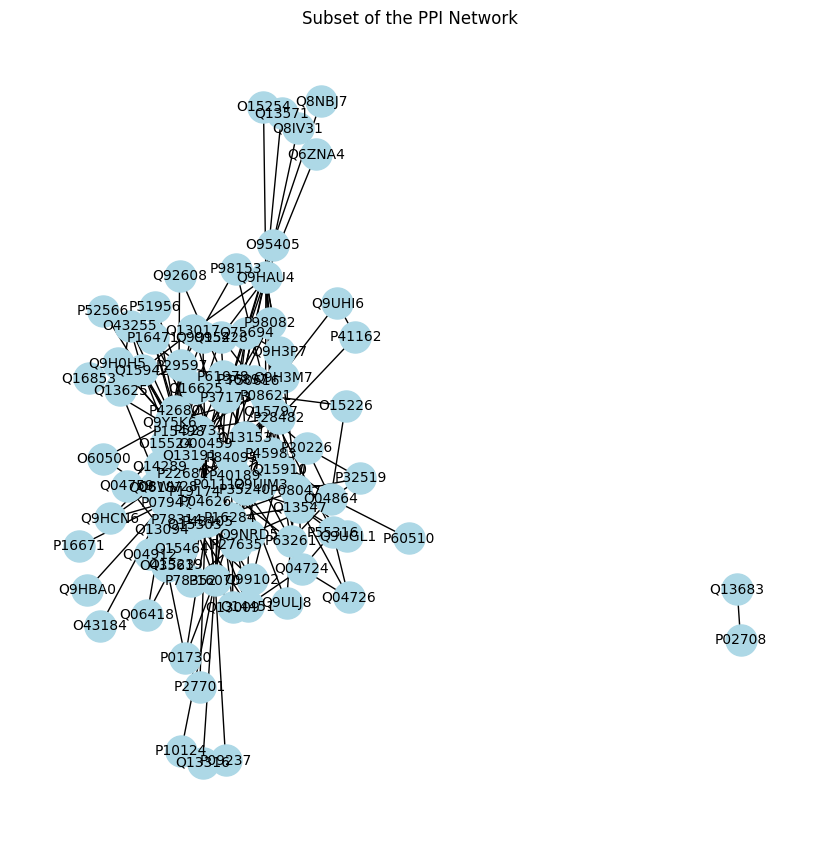

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you already have the full PPI graph G
# Select a subset of nodes (for example, the first 10 nodes)
subset_nodes = list(G.nodes())[:100]  # Select the first 1000 nodes from the full graph

# Extract the subgraph from the full graph
G_sub = G.subgraph(subset_nodes)

# Plot the subgraph
def plot_subgraph(G, title="Subgraph of PPI Network"):
    plt.figure(figsize=(8, 8))

    # Position the nodes using spring layout (you can use other layouts as well)
    pos = nx.spring_layout(G, seed=42)

    # Draw the nodes and edges
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

    plt.title(title)
    plt.show()

# Call the function to plot the subgraph
plot_subgraph(G_sub, title="Subset of the PPI Network")


## **Building MeSH similarity matrix**

The MeSH (Medical Subject Headings) dataset is a comprehensive controlled vocabulary used by the National Library of Medicine (NLM) to index articles for PubMed and other biomedical literature databases. It provides a hierarchical structure of medical terms that are used for cataloging, searching, and organizing biomedical information.

These are standardized keywords or phrases that describe the topics of biomedical articles. Each term represents a concept, such as diseases, chemicals, anatomical parts, or biological processes (e.g., "Cancer," "Proteins," "Inflammation").

Examples include :

**MeSH Term: "Hypertension"**

MeSH ID: D006973

Description: Hypertension is a condition where the blood pressure in the arteries is consistently elevated.

**MeSH Term: "Alzheimer Disease"**

MeSH ID: D000544

Description: Alzheimer’s Disease is a progressive, neurodegenerative disease characterized by memory loss, cognitive decline, and personality changes.

**MeSH Term: "Insulin Resistance"**

MeSH ID: D015906

Description: Insulin resistance refers to a diminished ability of cells to respond to the action of insulin in transporting glucose from the bloodstream.



MeSH terms are organized into a hierarchical structure, where broader terms encompass more specific sub-terms. For example, "Neoplasms" might include more specific terms like "Breast Neoplasms" or "Lung Neoplasms." This hierarchy allows for precise searching, either by broad categories or specific terms.

To extract the MeSH terms to build the similarity matrix we'll use the tool DiShIn developed by Biomedical Text Mining Team at Universidade de Lisboa.

**Clone the DiShIn repository from github and dowload the MeSH dataset**

In [ ]:
!git clone https://github.com/lasigeBioTM/DiShIn.git
%cd DiShIn

Cloning into 'DiShIn'...
remote: Enumerating objects: 1086, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 1086 (delta 43), reused 51 (delta 16), pack-reused 984 (from 1)
Receiving objects: 100% (1086/1086), 25.79 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (654/654), done.
/content/DiShIn


In [ ]:
!curl -L -O ftp://nlmpubs.nlm.nih.gov/online/mesh/rdf/mesh.nt.gz
!gunzip mesh.nt.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  129M  100  129M    0     0  30.4M      0  0:00:04  0:00:04 --:--:-- 30.4M


In [ ]:

import os
import random

def extract_broader_descriptor_triples(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            if "http://id.nlm.nih.gov/mesh/vocab#broaderDescriptor" in line:
                outfile.write(line)



def extract_broader_descriptor_triples_subset(input_file, output_file, fraction=0.1):
    """
    Extract triples with the 'broaderDescriptor' predicate and subsample to a given fraction.

    :param input_file: The file containing the original RDF triples.
    :param output_file: The file to write the subsampled triples.
    :param fraction: The fraction of triples to keep (e.g., 0.1 for 1/10th).
    """
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            if "http://id.nlm.nih.gov/mesh/vocab#broaderDescriptor" in line:
                if random.random() < fraction:
                    outfile.write(line)


# Create complete file
# extract_broader_descriptor_triples("mesh.nt", "mesh_broader_descriptor.nt")

# Create a subsampled file with 1/10th of the triples
extract_broader_descriptor_triples_subset("mesh.nt", "mesh_broader_descriptor_subsampled.nt", fraction=0.1)


**Extract the MeSH terms and build a mesh databaset and then calculate the similarity**

In [ ]:
import sqlite3

def check_database_entries(db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    cursor.execute("SELECT COUNT(*) FROM entry")
    count = cursor.fetchone()[0]
    print(f"Number of entries in the database: {count}")

    conn.close()
    return count

# Check the number of entries in the subset database
total_entry_meshdb = check_database_entries("mesh.db")


Number of entries in the database: 6486


In [ ]:
import ssmpy
import numpy as np

ssmpy.create_semantic_base("mesh_broader_descriptor_subsampled.nt", "mesh.db", "http://id.nlm.nih.gov/mesh/", "http://id.nlm.nih.gov/mesh/vocab#broaderDescriptor", '')

ssmpy.semantic_base("mesh.db")


MeSHName = []
for i in range (1,100000):
    temp = ssmpy.get_name(i)
    MeSHName.append(temp)

MeSHName = np.array(MeSHName)
MeSHName = np.unique(MeSHName)
MeSHName = np.delete(MeSHName,0)
del i
del temp

loading the ontology mesh_broader_descriptor_subsampled.nt
calculating transitive closure at distance: 1
calculating transitive closure at distance: 2
calculating transitive closure at distance: 3
calculating transitive closure at distance: 4
calculating the descendents
calculating the hierarchical frequency
the end


In SSMPy (Semantic Similarity Measures in Python), the functions ssm_resnik, ssm_lin, and ssm_jiang_conrath are used to calculate the semantic similarity between terms based on their position in an ontology (like Gene Ontology or MeSH). These similarity measures leverage the Information Content (IC) of terms, which reflects how specific or informative a term is within the ontology. Here’s a detailed explanation of each measure:



1. Resnik Similarity (ssm_resnik)
Definition: Resnik similarity calculates the similarity between two terms by finding their most informative common ancestor (MICA), i.e., the common ancestor that has the highest information content (IC) in the ontology.

Formula:
$$
\text{Resnik similarity} = IC(\text{MICA}(t1, t2))
$$


Explanation:

Resnik's measure focuses on the shared information between two terms.
The more specific (higher IC) the common ancestor is, the higher the similarity score.
This method doesn't account for how much information is not shared between the terms, just what is shared.
Range: The score is non-negative and higher values indicate higher similarity.

Example Use: Resnik is useful when you want to know how much shared information two terms have based on their most specific common ancestor in the ontology.

2. Lin Similarity (ssm_lin)
Definition: Lin similarity improves upon Resnik by normalizing the shared information by the amount of information in the individual terms, ensuring that the similarity is bounded between 0 and 1.

Formula:

$$
\text{Lin similarity} = \frac{2 \times IC(\text{MICA}(t1, t2))}{IC(t1) + IC(t2)}
$$

Explanation:

Lin's measure considers not only the shared information (like Resnik) but also how different the two terms are.
It compares the common information between the two terms relative to the individual information content of each term.
This makes the measure more balanced and interpretable compared to Resnik.
Range: The value ranges from 0 to 1, where:

1 indicates identical terms.
0 indicates no similarity.
Example Use: Lin's similarity is commonly used when you want a normalized similarity score between two terms, which reflects both shared and distinct information content.

3. Jiang-Conrath Similarity (ssm_jiang_conrath)
Definition: Jiang-Conrath similarity uses a distance-based approach, combining both the shared information and the unique information of the terms. It measures the distance between two terms based on their IC values and the IC of their most informative common ancestor.

Formula:

$$
\text{Jiang-Conrath distance} = IC(t1) + IC(t2) - 2 \times IC(\text{MICA}(t1, t2))
$$


The similarity is often taken as the inverse of this distance:

$$
\text{Jiang-Conrath similarity} = \frac{1}{1 + \text{Jiang-Conrath distance}}
$$

Explanation:

Jiang-Conrath measures how far apart two terms are in terms of their shared and individual information content.
The lower the distance, the higher the similarity.
It is useful when you want to balance between the shared information and how much each term deviates from that shared information.
Range: Similarity is also typically normalized between 0 and 1, where:

0 indicates maximum distance (no similarity).
1 indicates identical terms.
Example Use: Jiang-Conrath is helpful when you're interested in measuring the dissimilarity between terms and want to quantify both the shared and unique aspects of the terms.

In [ ]:


DiseSimeResnik = np.zeros((len(MeSHName),len(MeSHName)))
DiseSimeLin = np.zeros((len(MeSHName),len(MeSHName)))
DiseSimeJiang = np.zeros((len(MeSHName),len(MeSHName)))

for i in range (0,total_entry_meshdb):
    for j in range (i+1,total_entry_meshdb):
        e1 = ssmpy.get_id(MeSHName[i,])
        e2 = ssmpy.get_id(MeSHName[j,])

        temp1 = ssmpy.ssm_resnik(e1,e2)
        DiseSimeResnik[i,j] = temp1
        temp2 = ssmpy.ssm_lin(e1,e2)
        DiseSimeLin[i,j] = temp2
        temp3 = ssmpy.ssm_jiang_conrath(e1,e2)
        DiseSimeJiang[i,j] = temp3

In [ ]:
import numpy as np
import ssmpy

# Precompute IDs for all MeSH terms to avoid redundant calls
mesh_ids = [ssmpy.get_id(name) for name in MeSHName]

# Initialize similarity matrices
DiseSimeResnik = np.zeros((len(MeSHName), len(MeSHName)))
DiseSimeLin = np.zeros((len(MeSHName), len(MeSHName)))
DiseSimeJiang = np.zeros((len(MeSHName), len(MeSHName)))

# Use upper triangular indices to avoid redundant computations
indices = np.triu_indices(len(MeSHName), k=1)

# Sequential computation of similarities for all pairs
for i, j in zip(indices[0], indices[1]):
    e1 = mesh_ids[i]
    e2 = mesh_ids[j]

    lin = ssmpy.ssm_lin(e1, e2)

    DiseSimeLin[i, j] = lin
    DiseSimeLin[j, i] = lin  # Symmetry



In [ ]:
print("Lin Similarity Matrix Sample:\n", DiseSimeLin[:5, :5])


Lin Similarity Matrix Sample:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


## **Disease Protein Association matrix using OMIM**

In [ ]:
%cd /content

/content


**Download uniprot_sprot_human.dat file**

The uniprot_sprot_human.dat.gz file is a compressed flat file from the UniProt database, specifically containing Swiss-Prot entries for human proteins.
It's a manually annotated and reviewed section that contains curated information about protein sequences and functions.

In [ ]:
link = "https://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/taxonomic_divisions/uniprot_sprot_human.dat.gz"
!wget {link}
!gunzip uniprot_sprot_human.dat.gz

--2024-09-16 14:48:40--  https://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/taxonomic_divisions/uniprot_sprot_human.dat.gz
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111215934 (106M) [application/x-gzip]
Saving to: ‘uniprot_sprot_human.dat.gz’

uniprot_sprot_human 100%[===================>] 106.06M  86.2MB/s    in 1.2s    

2024-09-16 14:48:41 (86.2 MB/s) - ‘uniprot_sprot_human.dat.gz’ saved [111215934/111215934]



**Extract disease information and build protein-disease association matrix**


 Our goal is to parse a UniProt flat file (uniprot_sprot_human.dat) and extract specific information about proteins, including their identifiers, accession numbers, and associated OMIM disease IDs.

**OMIM (Online Mendelian Inheritance in Man)** is a comprehensive, authoritative, and continuously updated database of human genes and genetic disorders. It catalogues the relationships between genetic mutations and phenotypic effects, particularly focusing on inherited diseases. Each entry in OMIM provides detailed information on the molecular mechanisms of genetic disorders, gene function, clinical symptoms, and relevant literature references.


Example of OMIM:

**OMIM Term: "Cystic Fibrosis"**

OMIM ID: 219700

Description: Cystic Fibrosis is a genetic disorder that affects the respiratory and digestive systems due to a mutation in the CFTR gene.

**OMIM Term: "Huntington Disease"**

OMIM ID: 143100

Description: Huntington Disease is a progressive neurodegenerative genetic disorder characterized by movement disorders, cognitive decline, and psychiatric symptoms. It is caused by mutations in the HTT gene.

**OMIM Term: "Familial Hypercholesterolemia"**

OMIM ID: 143890

Description: Familial Hypercholesterolemia is a genetic disorder characterized by high cholesterol levels, particularly low-density lipoprotein (LDL), leading to early cardiovascular disease. Mutations in the LDLR gene are commonly implicated.

In the context of protein-disease association, OMIM is highly relevant because many diseases are linked to specific proteins whose malfunction or mutation results in pathological conditions. OMIM provides unique identifiers (MIM IDs) for genetic diseases, which can be used to connect specific proteins to particular diseases. By cross-referencing protein sequences and functions from databases like UniProt with OMIM disease IDs, we can map how different proteins are involved in various diseases. This connection between proteins and diseases enables the study of genetic disorders, facilitates drug target discovery, and helps in understanding the underlying biology of diseases for diagnostic and therapeutic purposes.

The **protein-disease association matrix** is a binary matrix used to represent the associations between proteins and diseases based on OMIM IDs. Each row in the matrix corresponds to a protein, while each column corresponds to a unique OMIM disease identifier. The matrix is initialized as a zero-filled array, where a value of 1 indicates that a specific protein is associated with a given disease, and a 0 indicates no known association. This structure helps efficiently map and visualize the relationships between proteins and diseases.

The matrix is built by first extracting protein IDs, their accession numbers, and the corresponding OMIM disease IDs from the UniProt file. For each protein entry that contains disease-related information, the OMIM IDs are extracted and stored in lists. After compiling a list of all unique OMIM IDs, the matrix is populated by iterating over the extracted protein-disease pairs. For each protein, the associated diseases are identified, and the matrix is updated by placing 1s in the cells corresponding to the protein-disease associations, thus constructing a clear and concise mapping of protein involvement in specific genetic diseases.

In [ ]:
def matchstart(string, pattern):
    """Checks if the start of the string matches the pattern."""
    return bool(re.match(r'^' + pattern, string))

def extractfield(entries, ln, line_id):
    """Extracts a field from the text entries."""
    start_ln = ln
    while matchstart(entries[ln], line_id):
        ln += 1
    data = "\n".join([entry[6:] for entry in entries[start_ln:ln]])
    return data, ln


In [ ]:
# Initialize data structures
prot_id = []
prot_ac = []
prot_dise_omim = []

# Function to extract fields from an entry
def extractfield(entries, ln, field):
    while not entries[ln].startswith(field) and ln < len(entries):
        ln += 1
    return entries[ln], ln + 1

# Read the UniProt file (assuming it's in the EMBL flat file format)
with open('uniprot_sprot_human.dat', 'r') as file:
    entries = []
    for line in file:
        entries.append(line.strip())
        if line.strip() == "//":  # Entry delimiter
            # Process each entry
            ln = 0
            tempid, ln = extractfield(entries, ln, "ID   ")
            tempid = re.findall(r'\w+_HUMAN', tempid)

            # Check if tempid contains valid data
            if tempid:
                tempac, ln = extractfield(entries, ln, "AC   ")
                tempac = re.findall(r'[\w]{6}', tempac)
                # tempac = [ac for ac_list in re.findall(r'\w{6}', tempac) for ac in ac_list]
                # Extract disease information
                line_dise = [i for i, entry in enumerate(entries) if entry.startswith('CC   -!- DISEASE:')]
                tempmim = []
                if line_dise:
                    for dise_ln in line_dise:
                        ln = dise_ln + 1
                        while matchstart(entries[ln], 'CC       '):
                            ln += 1
                        ln -= 1

                        temp = re.findall(r'\[MIM:\d{6}\]', "\n".join(entries[dise_ln:ln+1]))
                        tempmim.extend([mim[5:-1] for mim in temp])

                tempmim = list(set(tempmim))  # Unique OMIM IDs
                if tempmim:
                    prot_id.append(tempid[0])
                    prot_ac.append(tempac)
                    prot_dise_omim.append(tempmim)

            entries = []  # Clear entries for the next entry


In [ ]:
# Extract unique OMIM IDs
omim = list(set([omim_id for sublist in prot_dise_omim for omim_id in sublist]))
# Initialize the protein-disease association matrix
prot_dise_asso_matr = np.zeros((len(prot_id), len(omim)), dtype=int)

# Populate the matrix
for i, omims in enumerate(prot_dise_omim):
    for omim_id in omims:
        line_dise = omim.index(omim_id)
        prot_dise_asso_matr[i, line_dise] = 1

In [ ]:
print(prot_id)
print(prot_ac)
print(prot_dise_omim)
print(prot_dise_asso_matr)

['1433G_HUMAN', '2A5D_HUMAN', '2AAA_HUMAN', '2ABB_HUMAN', '3BHS2_HUMAN', '3BHS7_HUMAN', '3BP2_HUMAN', '3HAO_HUMAN', '5HT1A_HUMAN', '5NT3A_HUMAN', '5NTC_HUMAN', '5NTD_HUMAN', 'A16L1_HUMAN', 'A1AT_HUMAN', 'A2AP_HUMAN', 'A2ML1_HUMAN', 'A4_HUMAN', 'AAAS_HUMAN', 'AAGAB_HUMAN', 'AAKG2_HUMAN', 'AASS_HUMAN', 'AATM_HUMAN', 'ABCA1_HUMAN', 'ABCA2_HUMAN', 'ABCA3_HUMAN', 'ABCA4_HUMAN', 'ABCA7_HUMAN', 'ABCAC_HUMAN', 'ABCB6_HUMAN', 'ABCB7_HUMAN', 'ABCBB_HUMAN', 'ABCC8_HUMAN', 'ABCC9_HUMAN', 'ABCD1_HUMAN', 'ABCD3_HUMAN', 'ABCD4_HUMAN', 'ABCG5_HUMAN', 'ABCG8_HUMAN', 'ABD12_HUMAN', 'ABHD5_HUMAN', 'ABHGA_HUMAN', 'ABL1_HUMAN', 'ABRX1_HUMAN', 'ACACA_HUMAN', 'ACAD8_HUMAN', 'ACAD9_HUMAN', 'ACADM_HUMAN', 'ACADS_HUMAN', 'ACADV_HUMAN', 'ACATN_HUMAN', 'ACBD5_HUMAN', 'ACDSB_HUMAN', 'ACD_HUMAN', 'ACER3_HUMAN', 'ACE_HUMAN', 'ACHA2_HUMAN', 'ACHA3_HUMAN', 'ACHA4_HUMAN', 'ACHA_HUMAN', 'ACHB2_HUMAN', 'ACHB_HUMAN', 'ACHD_HUMAN', 'ACHE_HUMAN', 'ACHG_HUMAN', 'ACKR3_HUMAN', 'ACL6B_HUMAN', 'ACL7A_HUMAN', 'ACM2_HUMAN', 'ACM3

## **Map MeSH and OMIM entry to build a comprehensive Disease-protein-association network**

Mapping MeSH (Medical Subject Headings) and OMIM (Online Mendelian Inheritance in Man) entries is essential for building a comprehensive disease-protein association network for several reasons.

MeSH terms provide a standardized vocabulary for diseases, which is widely used in the biomedical literature and databases like PubMed. On the other hand, OMIM focuses on genetic diseases, linking genes and proteins to their roles in hereditary conditions. By mapping these two resources, we can bridge the gap between clinical disease descriptions (MeSH) and molecular genetic data (OMIM), ensuring that the network captures a wide range of disease types, from common medical conditions to rare genetic disorders.

A comprehensive network that maps both clinical symptoms (MeSH) and genetic causes (OMIM) to proteins can offer more precise disease associations. This is particularly useful for drug discovery, where identifying protein targets involved in a range of diseases—both clinical and genetic—can help in developing targeted therapies. Moreover, mapping genetic data (OMIM) to clinical outcomes (MeSH) helps in personalized medicine, where treatments can be tailored based on the specific genetic mutations and clinical presentation of a disease.

An example of MeSH to OMIM mapping:

1. MeSH Term: "Hypertension" ; MeSH ID: D006973
   
   OMIM Mappings:
   - OMIM ID: 145500 (Hypertension, Essential)
   - OMIM ID: 601338 (Hypertension, Pulmonary Arterial)
  - OMIM ID: 177850 (Hypertension, Renal)
2. MeSH Term: "Alzheimer Disease" ;   MeSH ID: D000544

  OMIM Mappings:
 - OMIM ID: 104300 (Alzheimer Disease, Type 1)
 - OMIM ID: 104310 (Alzheimer Disease, Type 2)
 - OMIM ID: 607822 (Alzheimer Disease, Type 3)
3. MeSH Term: "Insulin Resistance" ; MeSH ID: D015906

   OMIM Mappings:
   - OMIM ID: 125853 (Insulin Resistance, Type A)
   - OMIM ID: 610549 (Insulin Resistance, Type B)
   - OMIM ID: 616943 (Insulin Resistance Syndrome with Hyperandrogenism)


In [ ]:
link = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/docs/humdisease.txt"
!wget {link}

--2024-09-16 14:49:10--  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/docs/humdisease.txt
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4455540 (4.2M) [text/plain]
Saving to: ‘humdisease.txt’

humdisease.txt      100%[===================>]   4.25M  16.3MB/s    in 0.3s    

2024-09-16 14:49:10 (16.3 MB/s) - ‘humdisease.txt’ saved [4455540/4455540]



In [ ]:
import re
import csv

def extract_ids(filename):
    # Define patterns to capture DI, OMIM, and MeSH IDs
    di_pattern = re.compile(r"AC\s+(DI-\d+)")
    omim_pattern = re.compile(r"MIM; (\d+); phenotype")
    mesh_pattern = re.compile(r"MeSH; (D\d+)")

    # Prepare to store mappings
    mappings = []

    # Open and read the file
    with open(filename, 'r') as file:
        content = file.read()

    # Split the content into entries
    entries = content.split('//\n')
    for entry in entries:
        di = di_pattern.search(entry)
        omims = omim_pattern.findall(entry)
        mesh_ids = mesh_pattern.findall(entry)

        if di:
            di_code = di.group(1)
            for omim_id in omims:
                for mesh_id in mesh_ids:
                    mappings.append({
                        'DI': di_code,
                        'OMIM': omim_id,
                        'MeSH': mesh_id
                    })

    return mappings

def save_to_csv(mappings, output_filename):
    with open(output_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['DI', 'OMIM', 'MeSH'])
        for mapping in mappings:
            # Ensure each dictionary is converted to a tuple in the correct order
            writer.writerow([mapping['DI'], mapping['OMIM'], mapping['MeSH']])

filename = 'humdisease.txt'
output_filename = 'humdisease_mappings.csv'
mappings = extract_ids(filename)
save_to_csv(mappings, output_filename)

In [ ]:
# Example dataset snapshot
omim_mesh_data = mappings
# Build a dictionary to map OMIM -> List of MeSH IDs
omim_to_mesh = {}
ProtID = prot_id


for entry in omim_mesh_data:
    omim = entry['OMIM']
    mesh = entry['MeSH']
    if omim in omim_to_mesh:
        omim_to_mesh[omim].append(mesh)
    else:
        omim_to_mesh[omim] = [mesh]


In [ ]:
ProtDiseAssoMatr = prot_dise_asso_matr


# List to store the updated associations with MeSH terms
ProtDiseOMIMMeSHAsso = []

# Loop over the protein-disease OMIM associations
for i, omim_list in enumerate(prot_dise_omim):
    protein_id = ProtID[i]  # Get the corresponding protein ID
    for omim in omim_list:
        if omim in omim_to_mesh:
            mesh_list = omim_to_mesh[omim]
            for mesh in mesh_list:
                # Add the association (Protein ID, OMIM, MeSH)
                ProtDiseOMIMMeSHAsso.append([protein_id, omim, mesh])


In [ ]:
import numpy as np

# Get the unique OMIM and MeSH terms
unique_omim = list(omim_to_mesh.keys())  # Unique OMIM IDs
unique_mesh = list(set([mesh for meshes in omim_to_mesh.values() for mesh in meshes]))  # Unique MeSH terms

# Assume there are N proteins (based on your data)
num_proteins = len(prot_dise_omim)

# Create an empty matrix with size (num_proteins x (len(unique_omim) + len(unique_mesh)))
association_matrix = np.zeros((num_proteins, len(unique_omim) + len(unique_mesh)))

# Map OMIMs and MeSH to column indices
omim_col_map = {omim: idx for idx, omim in enumerate(unique_omim)}
mesh_col_map = {mesh: idx + len(unique_omim) for idx, mesh in enumerate(unique_mesh)}

# Fill the matrix based on associations
for i, omim_list in enumerate(prot_dise_omim):
    for omim in omim_list:
        if omim in omim_col_map:
            # Set OMIM association
            omim_idx = omim_col_map[omim]
            association_matrix[i, omim_idx] = 1

        if omim in omim_to_mesh:
            # Set MeSH associations for this OMIM
            for mesh in omim_to_mesh[omim]:
                mesh_idx = mesh_col_map[mesh]
                association_matrix[i, mesh_idx] = 1

# The association_matrix now contains a 1 if there is an association between a protein and OMIM/MeSH ID


## **Final Graph**

Now we build a heterogenous graph of Human PPI, MeSH, OMIM and uniprot dataset containing disease and protein nodes, edges between two diseases, two proteins, disease and protein.

In [ ]:
# Extract the necessary fields
HumanProteID = prot_id
HumanProteSeq = prot_seq
MeSHName = MeSHName
DiseSimeLin = DiseSimeLin
ProtDiseOMIMMeSHAsso = ProtDiseOMIMMeSHAsso

In [ ]:
# Initialize a list to store valid indices
valid_indices = []

# Loop through all the associations and filter out invalid ones
for i in range(len(ProtDiseOMIMMeSHAsso)):
    protein = ProtDiseOMIMMeSHAsso[i][0]
    disease = ProtDiseOMIMMeSHAsso[i][2]
    # Check if the protein exists in the human PPI and the disease in MeSHName
    if protein in HumanProteID and disease in MeSHName:
        valid_indices.append(i)

# Filter the associations to keep only valid ones
filtered_ProtDiseOMIMMeSHAsso = [ProtDiseOMIMMeSHAsso[i] for i in valid_indices]


In [ ]:
# Create an empty association matrix of zeros
num_proteins = len(HumanProteID)
num_diseases = len(MeSHName)
ProtDiseAssoMatr = np.zeros((num_proteins, num_diseases))

# Loop through filtered associations and populate the matrix
for assoc in filtered_ProtDiseOMIMMeSHAsso:
    protein = assoc[0]  # Get the protein ID
    disease = assoc[2]  # Get the disease ID

    # Find the index of the protein and disease
    protein_idx = HumanProteID.index(protein)
    disease_idx = np.where(MeSHName == disease)[0][0]
    # Set the association matrix entry to 1
    ProtDiseAssoMatr[protein_idx, disease_idx] = 1

In [ ]:
# Find known proteins with associations
KnowProtDise = np.unique([assoc[0] for assoc in filtered_ProtDiseOMIMMeSHAsso])

# Find intersection of known proteins and HumanProteID
_, IndicesProtDise, _ = np.intersect1d(HumanProteID, KnowProtDise, return_indices=True)

# Find known diseases with associated proteins
KnowDiseProt = np.unique([assoc[2] for assoc in filtered_ProtDiseOMIMMeSHAsso])
_, IndicesDiseProt, _ = np.intersect1d(MeSHName, KnowDiseProt, return_indices=True)


In [ ]:
# Save the matrix to a file
np.save('HumanProteinDiseaseAssociationMatrix.npy', ProtDiseAssoMatr)

# Export the upper triangular matrix
upper_triangular = np.triu(ProtDiseAssoMatr)

# Write the upper triangular matrix to a text file
with open('HumanPDNetwork.txt', 'w') as f:
    for i in range(len(upper_triangular)):
        for j in range(i, len(upper_triangular[i])):
            if upper_triangular[i, j] == 1:
                f.write(f'{i} {j} 1\n')


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new undirected graph
G = nx.Graph()

# Add nodes for all the proteins and diseases
for protein in HumanProteID:
    G.add_node(protein, type='protein')



for protein in prot_id:
    if protein not in G.nodes():
        G.add_node(protein, type='protein')

mesh_ids = []
for entry in mappings:
    mesh_ids.append(entry['MeSH'])

for disease in mesh_ids:
    if disease not in G.nodes():
      G.add_node(disease, type='disease')

for disease in MeSHName:
    G.add_node(disease, type='disease')

# Add edges for protein-disease associations
for assoc in filtered_ProtDiseOMIMMeSHAsso:
    protein = assoc[0]
    disease = assoc[2]
    G.add_edge(protein, disease)


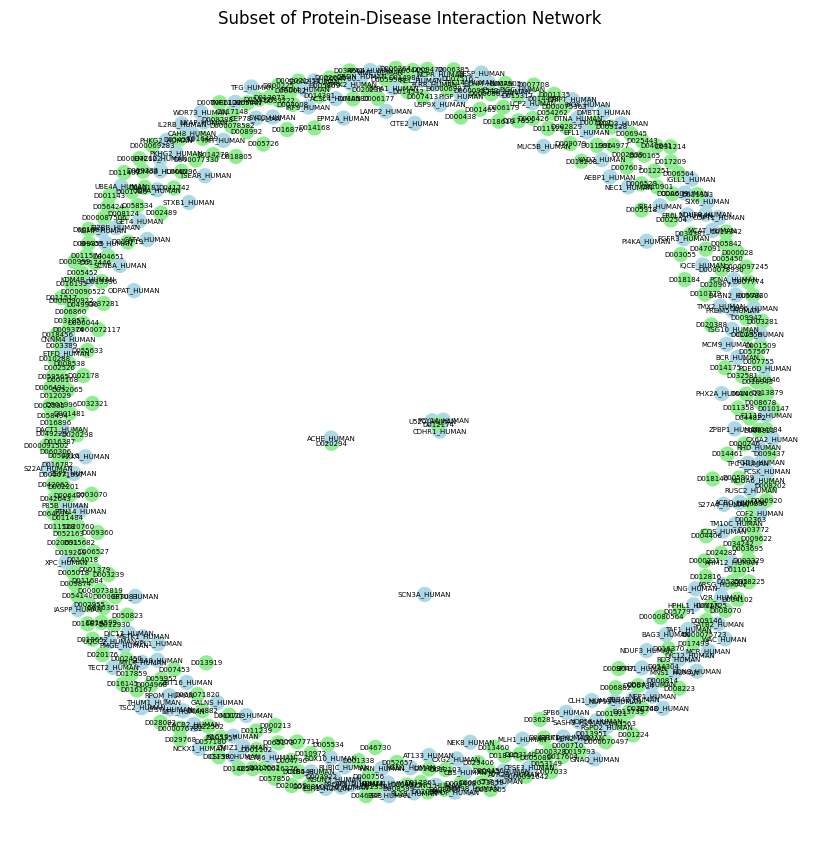

In [ ]:
# Select a random subset of nodes
subset_nodes = random.sample(list(G.nodes()),500)  # Select 100 random nodes from G
G_sub = G.subgraph(subset_nodes)

# ** Plot the Subgraph **

def plot_graph(graph, title="Protein-Disease Subgraph"):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(graph, seed=42)
    node_colors = ['lightblue' if G.nodes[node]['type'] == 'protein' else 'lightgreen' for node in graph.nodes()]

    # Draw nodes and edges
    nx.draw(graph, pos, with_labels=True, node_size=100, node_color=node_colors, font_size=5, font_weight='light')

    # Set plot title
    plt.title(title)
    plt.show()

# Plot the subgraph
plot_graph(G_sub, title="Subset of Protein-Disease Interaction Network")


## **Node2vec to learn node embeddings**

**Node2Vec** is a technique used to generate embeddings (vector representations) for nodes in a graph or network. It’s a machine learning algorithm that helps capture the relationships and similarities between nodes in a graph by converting them into numerical vectors. These vectors can then be used for various downstream tasks, like clustering, link prediction, or node classification.



For the graph we constructed above we need a way to represent the nodes in a graph as numerical vectors (a list of numbers) that a machine learning algorithm can understand. Node2Vec provides a way to do that by learning these node embeddings.


Node2Vec combines the idea of **random walks** on a graph with **word2vec** (a popular method for representing words as vectors). Here's a breakdown of how it works:

**Random Walks**: Imagine you start at a node and randomly "walk" to its neighboring nodes, then to their neighbors, and so on. This way, you explore the graph and create sequences of nodes, just like sentences made of words.

**Skip-Gram (Word2Vec):** The algorithm then applies a method similar to Word2Vec (a model used for word embeddings) to these random walks. In word2vec, words that appear in similar contexts (nearby in sentences) get similar vector representations. Similarly, in Node2Vec, nodes that frequently appear together in random walks get similar embeddings.


Node2Vec helps to capture relationships between nodes. Nodes that are close in the graph or share similar neighbors will have similar embeddings. These embeddings can be used to classify nodes, predict new connections (edges), or identify similar nodes, even without explicitly knowing their structure.

In [ ]:
import networkx as nx
from node2vec import Node2Vec
from gensim.models import Word2Vec
import numpy as np

# Step 1: Generate Random Walks using Node2Vec (which can act like DeepWalk)
node2vec = Node2Vec(G, dimensions=128, walk_length=80, num_walks=10, workers=2)  # Adjust dimensions, walk_length as needed

# Step 2: Fit the model using Word2Vec (this is similar to DeepWalk)
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Parameters can be tuned further


# You can access the embeddings for all nodes like this:
embeddings = {node: model.wv[node] for node in G.nodes()}

# Step 4: Save the embeddings to a file (optional)
np.save('protein_disease_embeddings.npy', embeddings)

Computing transition probabilities:   0%|          | 0/12030 [00:00<?, ?it/s]

In [ ]:
# Step 3: Access node embeddings
# Example: Get the embedding for a specific protein or disease
protein_embedding = model.wv['A2AP_HUMAN']  # Example: embedding for the protein 'A2AP_HUMAN'
disease_embedding = model.wv['D008105']     # Example: embedding for the disease 'D006474'


## **SVDD to construct the optimized hypersphere**



**SVDD (Support Vector Data Description)** algorithm is used to identify reliable protein-disease associations by modeling the positive (known) associations and distinguishing them from negative (unknown or false) associations. SVDD works by constructing a hypersphere in the feature space, which encompasses the majority of the positive samples (i.e., the valid protein-disease associations). The goal is to capture the general structure of the positive samples and then classify whether new samples (or negative ones) fall inside or outside this hypersphere.


**Support Vector Data Description (SVDD)** is an algorithm used for anomaly detection and one-class classification. It is designed to find a boundary that encloses normal data points (positive class) and identifies whether new data points are inside or outside this boundary. SVDD is similar to Support Vector Machine (SVM) but focuses on creating a compact boundary around the given data points rather than separating two classes.
SVDD aims to create a hypersphere (a multidimensional sphere) that encloses most of the data points (normal or positive class). The objective is to minimize the volume of this hypersphere while including as many data points as possible. The radius of this hypersphere is determined in such a way that it encloses the majority of the data. If a new data point falls inside the hypersphere, it is considered normal; if it falls outside, it is classified as an outlier or anomaly.

**Mathematical Formulation:**

The SVDD problem can be formulated as follows:

Let the dataset consist of
𝑛
n data points
{
𝑥
1
,
𝑥
2
,
…
,
𝑥
𝑛
}
{x
1
​
 ,x
2
​
 ,…,x
n
​
 } in a feature space.
SVDD finds a center
𝑐
c and a radius
𝑅
R such that the hypersphere encloses most of the data points while minimizing
𝑅
2
R
2
 .

The SVDD optimization problem is formulated as:

$$
\min_{R, c, \xi_i} \quad R^2 + C \sum_{i=1}^{n} \xi_i
$$

Subject to:

$$
\| x_i - c \|^2 \leq R^2 + \xi_i, \quad \xi_i \geq 0
$$

Where:
- \( c \) is the center of the hypersphere.
- \( R \) is the radius of the hypersphere.
- \( xi_i \) are slack variables that allow some points to be outside the hypersphere.
- \( C \) is a regularization parameter that balances the volume of the hypersphere and the tolerance for outliers.

Like SVM, SVDD can also use the kernel trick to map the data into a higher-dimensional feature space. This allows the algorithm to create more flexible, non-linear boundaries that can better capture the shape of the data. Common kernels include the Gaussian (RBF) kernel, which helps create a more adaptive boundary around the data.

**Training Process:**


The training process involves:

Finding the center
𝑐
c and the radius
𝑅
R that minimize the volume of the hypersphere.
Solving the optimization problem to include most data points while tolerating some outliers through slack variables ξ
i
​
 .


**Prediction (Testing)**

Once the SVDD model is trained, new data points can be tested. For a new data point
𝑥
x, the model checks if the point lies inside or outside the hypersphere:

Inside the hypersphere: The point is classified as normal (part of the positive class).
Outside the hypersphere: The point is classified as an outlier or anomaly.

Here's an overview of the code below:

**Positive Sample Features**: The algorithm first extracts features from known protein-disease associations using node2vec embeddings. These embeddings represent the proteins and diseases as vectors, and the SVDD model is trained using these vectors to enclose the positive associations within a hypersphere.

**Negative Sample Features**: After training the model on positive data, it tests it on negative samples (randomly generated protein-disease pairs) to identify those pairs that do not fit within the trained hypersphere, indicating that they are likely not true associations. By distinguishing between positive and negative samples, the SVDD helps in filtering out unreliable associations and improving the accuracy of the subsequent analysis.

This technique allows the model to better understand the "normal" positive associations and exclude irrelevant or incorrect associations, which can then be used for more accurate predictions and further classification using methods like Random Forest.



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, matthews_corrcoef

# Positive samples (already given as pairs of protein-disease)
PostProtDisePair = [[assoc[0], assoc[2]] for assoc in ProtDiseOMIMMeSHAsso]

# Generate negative samples by random pairing proteins and diseases not present in the positive set
np.random.seed(42)
NegProtDisePair = []

# Make a copy of positive pairs for exclusion
positive_set = set([f'{prot}-{disease}' for prot, disease in PostProtDisePair])

# Generate random negative pairs
while len(NegProtDisePair) < len(PostProtDisePair):
    prot = np.random.choice(HumanProteID)
    disease = np.random.choice(MeSHName)
    pair = f'{prot}-{disease}'
    if pair not in positive_set:
        NegProtDisePair.append([prot, disease])

In [ ]:
# Generate positive features
PosFeat = []
for prot, disease in PostProtDisePair:
    Pline = model.wv.get_vector(prot)
    Dline = model.wv.get_vector(disease)
    if Pline is not None and Dline is not None:
        PosFeat.append(np.concatenate([Pline, Dline]))

# Generate negative features
NegFeat = []
for prot, disease in NegProtDisePair:
    Pline = model.wv.get_vector(prot)
    Dline = model.wv.get_vector(disease)
    if Pline is not None and Dline is not None:
        NegFeat.append(np.concatenate([Pline, Dline]))

# Convert to numpy arrays
PosFeat = np.array(PosFeat)
NegFeat = np.array(NegFeat)

# Labels: 1 for positive, -1 for negative
PosAimout = np.ones(PosFeat.shape[0])
NegAimout = -1 * np.ones(NegFeat.shape[0])


In [ ]:
from sklearn.svm import OneClassSVM

# Train the SVDD (One-Class SVM) model on positive features
svdd = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
svdd.fit(PosFeat)

# Use the trained SVDD model to predict negative samples
svdd_predictions = svdd.predict(NegFeat)
reliable_negatives = NegFeat[svdd_predictions == -1]  # Select reliable negatives

## **Random Forest Classifier**

We now utilize a Random Forest Classifier to categorize disease-protein associations as either positive or negative.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix

# Prepare data for Random Forest (combine positive and selected negative samples)
X = np.vstack([PosFeat, reliable_negatives])
y = np.hstack([PosAimout, -1 * np.ones(reliable_negatives.shape[0])])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Test the model
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9721590909090909
Precision: 0.9749702026221693
Recall: 0.995739500912964


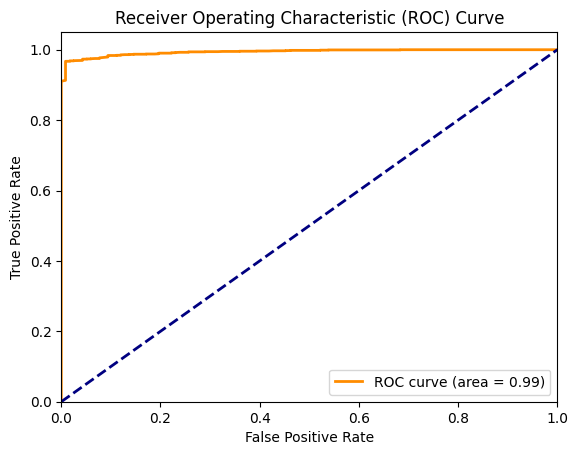

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
# Calculate the ROC curve and AUC
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
import matplotlib.pyplot as plt
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## References

1. Wenteler A, Cabrera CP, Wei W, Neduva V, Barnes MR. AI approaches for the discovery and validation of drug targets. Cambridge Prisms: Precision Medicine. 2024;2:e7. doi:10.1017/pcm.2024.4

2. Zhang, X., Wu, F., Yang, N. et al. In silico Methods for Identification of Potential Therapeutic Targets. Interdiscip Sci Comput Life Sci 14, 285–310 (2022). https://doi.org/10.1007/s12539-021-00491-y

3. https://github.com/ZhanchaoLi-gdpu/Disease-Protein-Associations

4. Safari-Alighiarloo N, Taghizadeh M, Rezaei-Tavirani M, Goliaei B, Peyvandi AA. Protein-protein interaction networks (PPI) and complex diseases. Gastroenterol Hepatol Bed Bench. 2014 Winter;7(1):17-31. PMID: 25436094; PMCID: PMC4017556.

5. Chen J, Gu Z, Lai L, Pei J. In silico protein function prediction: the rise of machine learning-based approaches. Med Rev (2021). 2023 Nov 29;3(6):487-510. doi: 10.1515/mr-2023-0038. PMID: 38282798; PMCID: PMC10808870.


# Congratulations! Time to join the Community!
Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:# Congratulations! Time to join the Community!
Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing this Tutorial

If you found this tutorial useful, please consider citing it as:

```
@manual{Bioinformatics,
 title={Disease Association with Graphs and Machine Learning},
 organization={DeepChem},
 author={Yadav, Anamika },
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Disease_Association_with_Graphs_and_Machine_Learning.ipynb}},
 year={2024},
}
```